In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os,sys
from PIL import Image
sys.path.append("..")

from utils import *
from errors import *

from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from scipy import ndimage as ndi
from scipy import ndimage as ndi
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches


Loading 20 images from images
Loading 20 images from groundtruth
Color images:
(11, 400, 400, 3)
(9, 400, 400, 3)
Gray images:
(11, 400, 400)
(9, 400, 400)


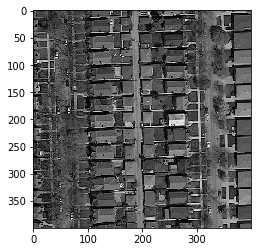

In [3]:
# Loaded a set of images
root_dir = "../../data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images from images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images from groundtruth")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

n_train = 11 # Only use 11 images for training
n_test = n - n_train
imgs_tr = [imgs[i] for i in range(n_train)]
imgs_te = [imgs[i] for i in range(n_train, n)]
imgs_gray_tr = [rgb2gray(imgs[i]) for i in range(n_train)]
imgs_gray_te = [rgb2gray(imgs[i]) for i in range(n_train, n)]

print("Color images:")
print(np.shape(imgs_tr))
print(np.shape(imgs_te))
print("Gray images:")
print(np.shape(imgs_gray_tr))
print(np.shape(imgs_gray_te))
plt.imshow(imgs_gray_tr[0], cmap='Greys_r')

In [4]:
sigma = 3

Blurred images:
(11, 400, 400)
(9, 400, 400)


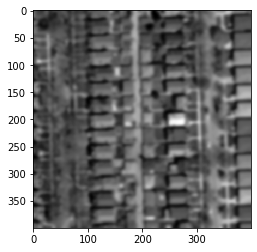

In [5]:
imgs_gray_blurred_tr = [ndi.gaussian_filter(imgs_gray_tr[i], sigma) for i in range(np.shape(imgs_gray_tr)[0])]
imgs_gray_blurred_te = [ndi.gaussian_filter(imgs_gray_te[i], sigma) for i in range(np.shape(imgs_gray_te)[0])]

print("Blurred images:")
print(np.shape(imgs_gray_blurred_tr))
print(np.shape(imgs_gray_blurred_te))
plt.imshow(imgs_gray_blurred_tr[0], cmap='Greys_r')

In [6]:
sigmamax = 2
edges = [[canny(imgs_gray_blurred_tr[i], sigma = s) for s in range(1,sigmamax+1)] for i in range(np.shape(imgs_gray_blurred_tr)[0])]
print(np.shape(edges))

(11, 2, 400, 400)


Image 1


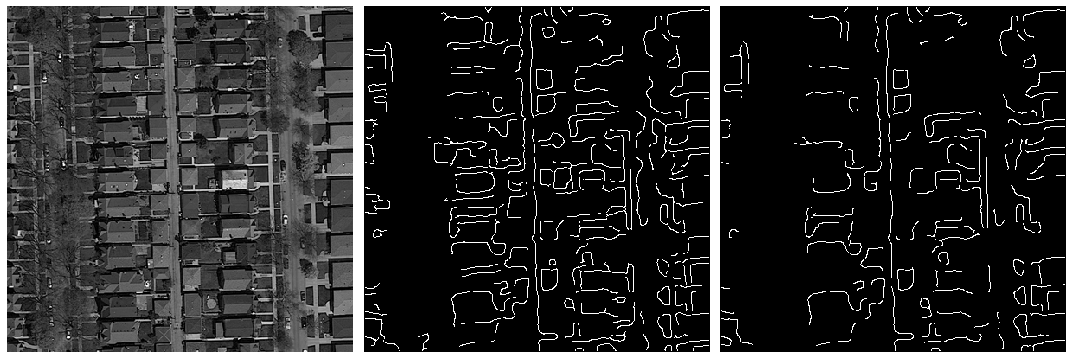

Image 2


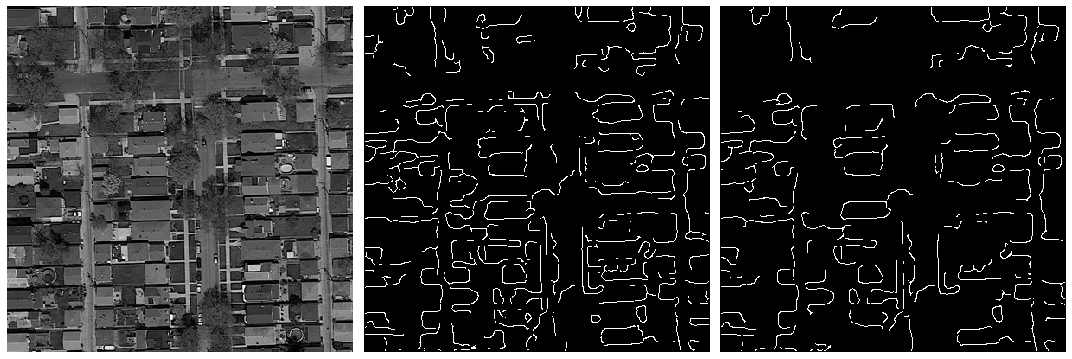

Image 3


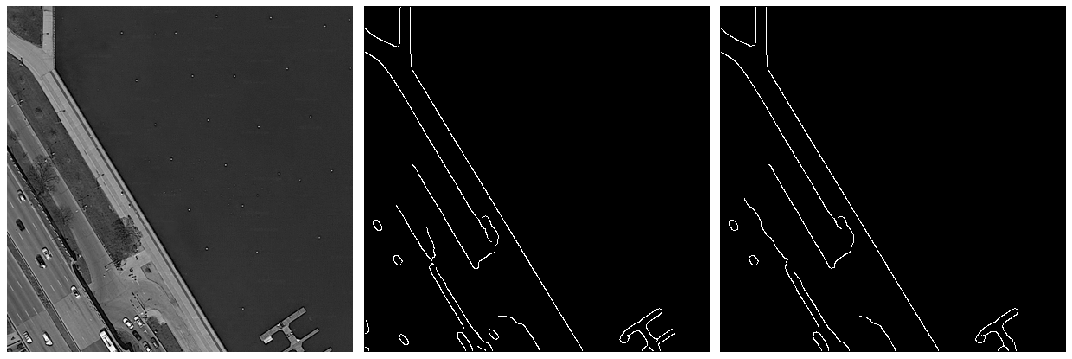

Image 4


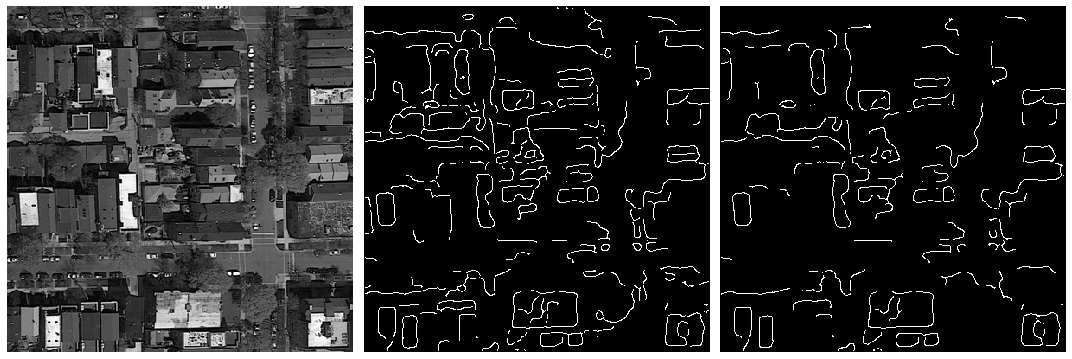

Image 5


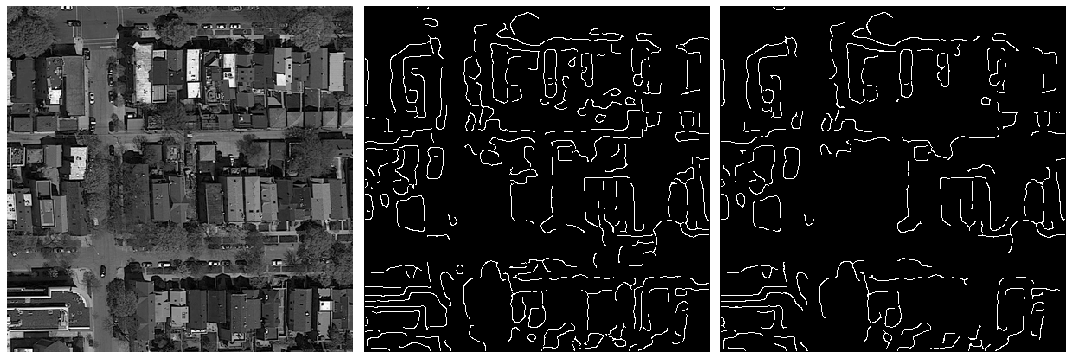

Image 6


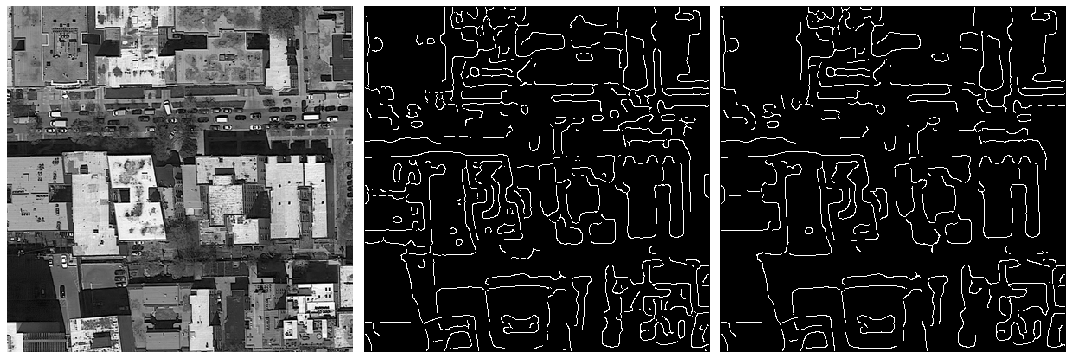

Image 7


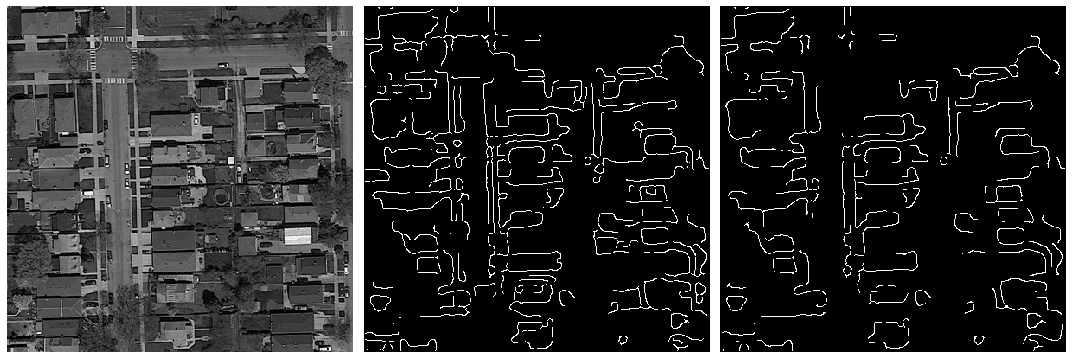

Image 8


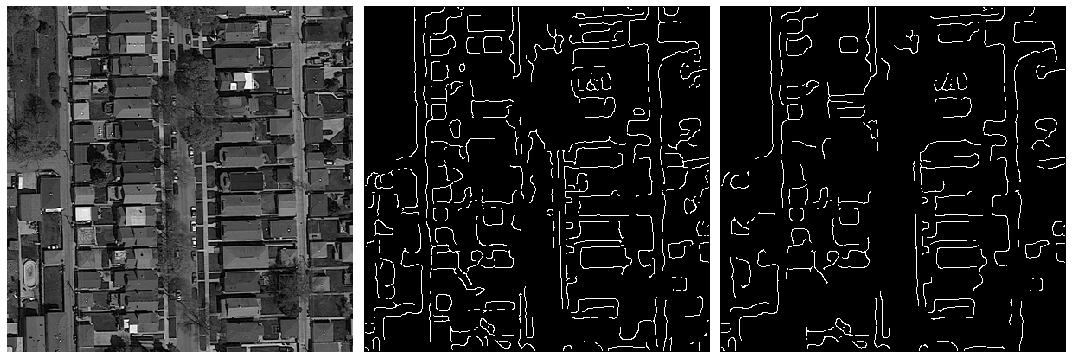

Image 9


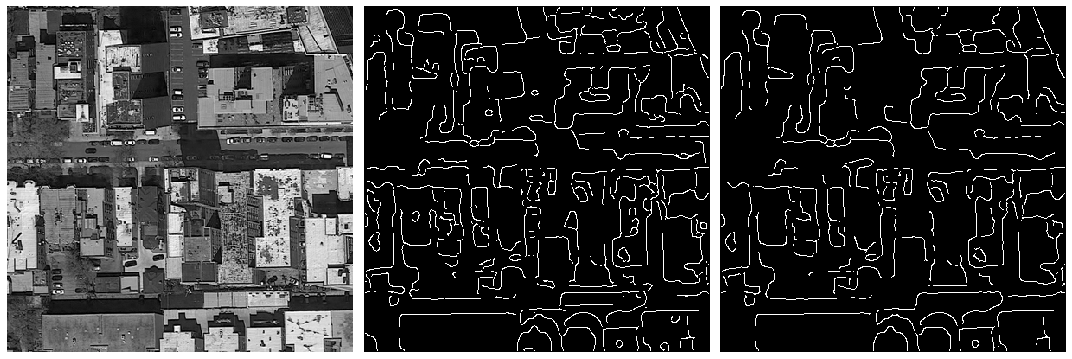

Image 10


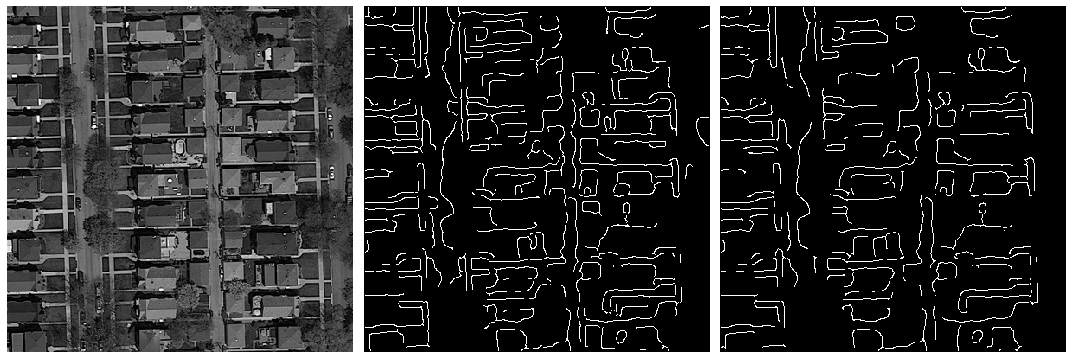

Image 11


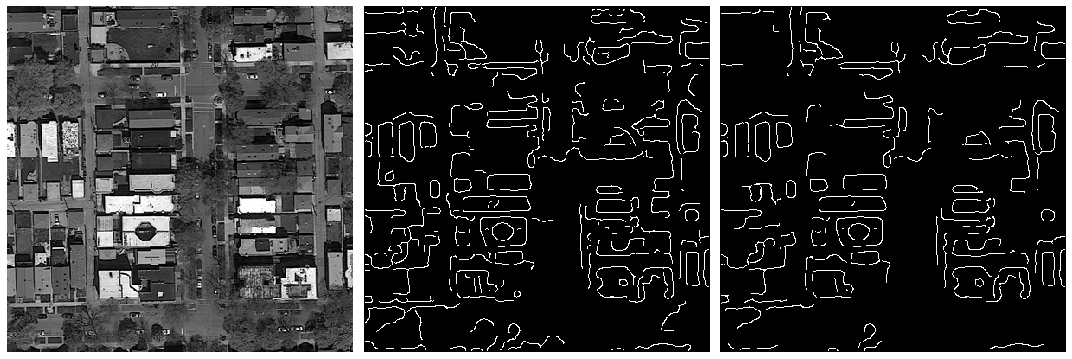

In [7]:
# display results

for i in range(np.shape(imgs_gray_tr)[0]):
    fig, ax = plt.subplots(nrows=1, ncols=sigmamax+1, figsize=(15, 6),
                                    sharex=True, sharey=True)
    print("Image " + str(i+1))
    ax[0].imshow(imgs_gray_tr[i], cmap=plt.cm.gray)
    ax[0].axis('off')
    for sigma in range(1, sigmamax+1):
        
        ax[sigma].imshow(edges[i][sigma-1], cmap=plt.cm.gray)
        ax[sigma].axis('off')

    fig.tight_layout()

    plt.show()

In [8]:
sigma_choosen = 1

idx_sigma = sigma_choosen - 1
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 180)

### Generation Hough transform for each canny edge image

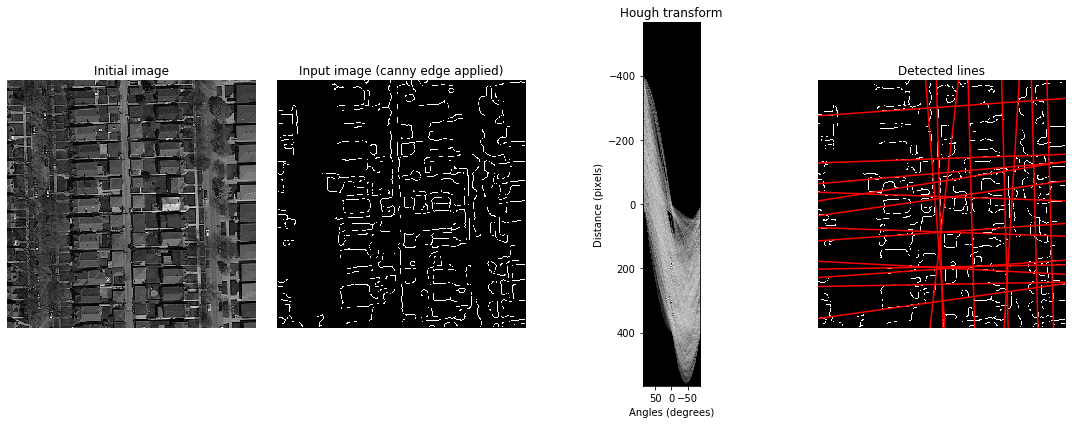

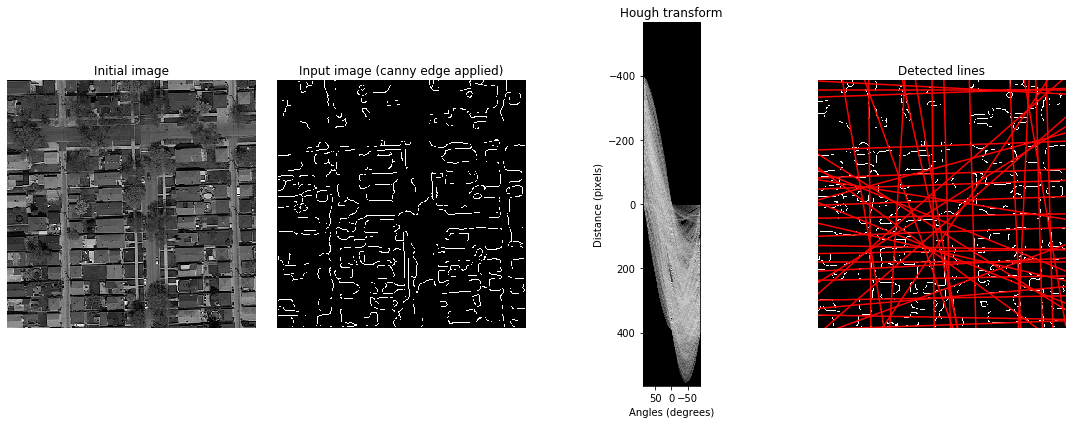

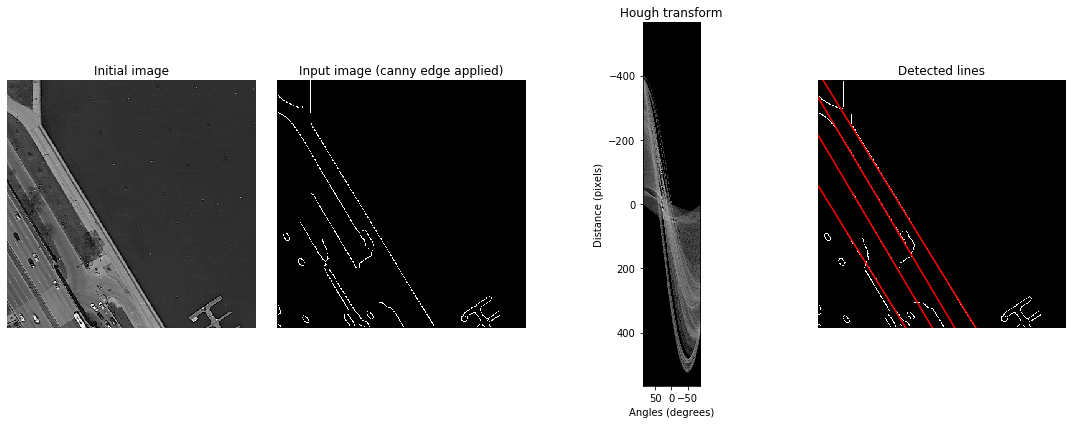

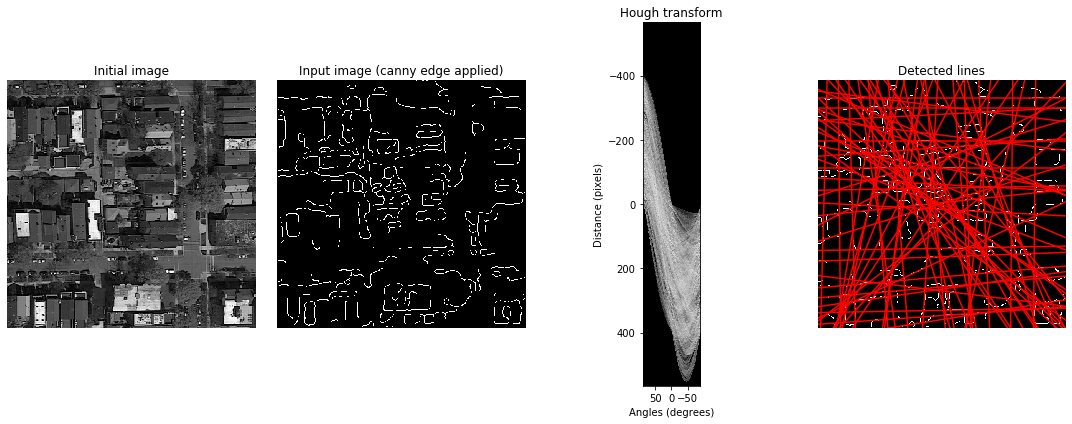

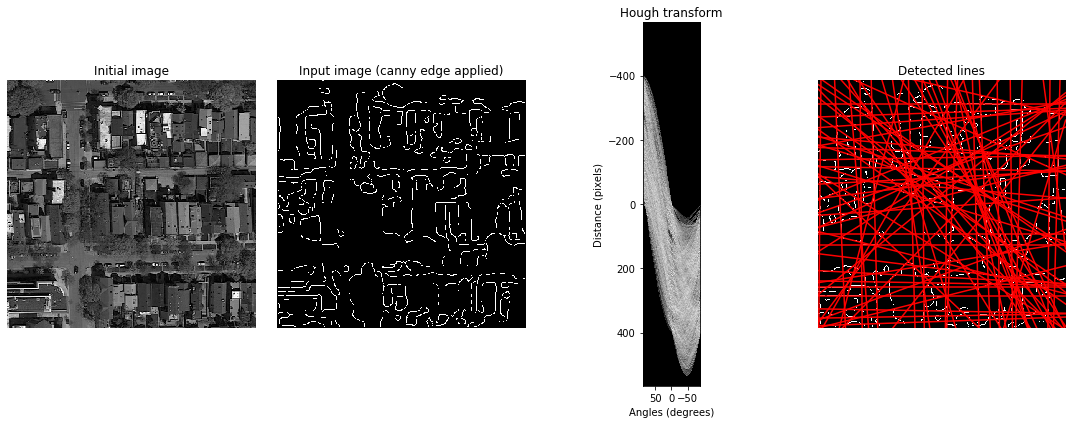

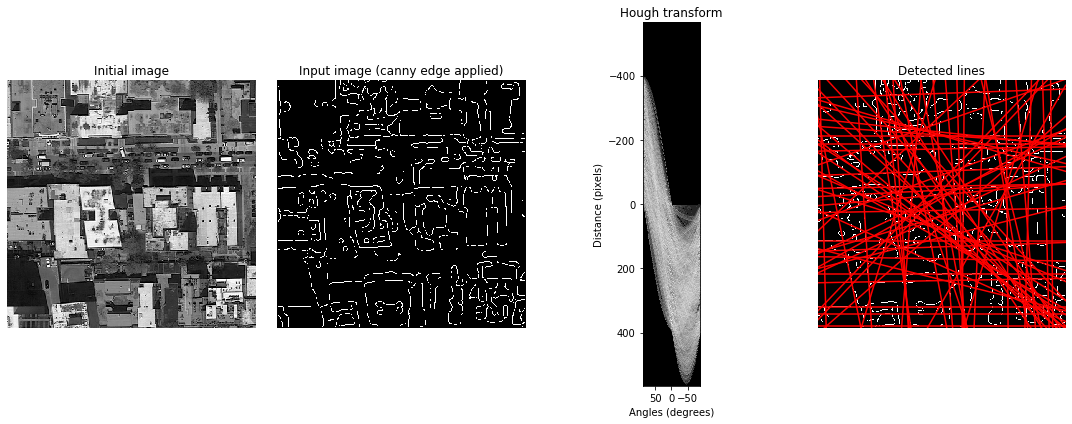

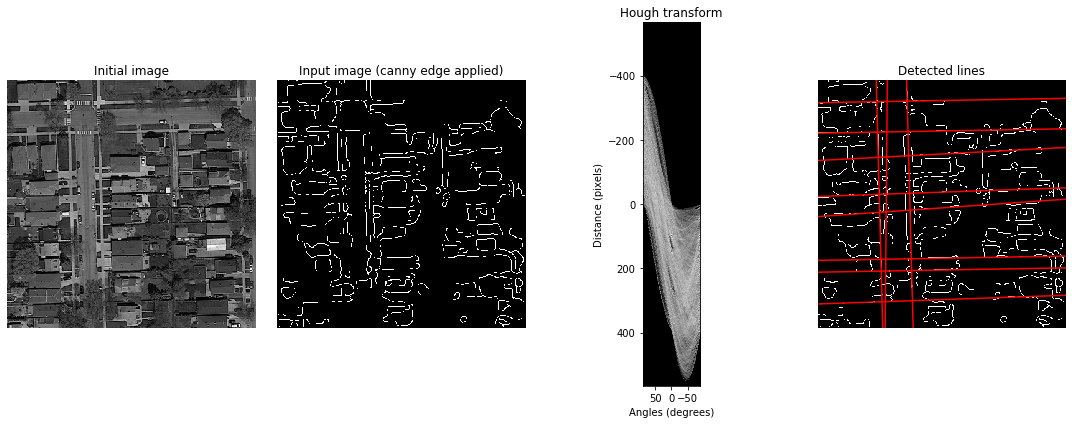

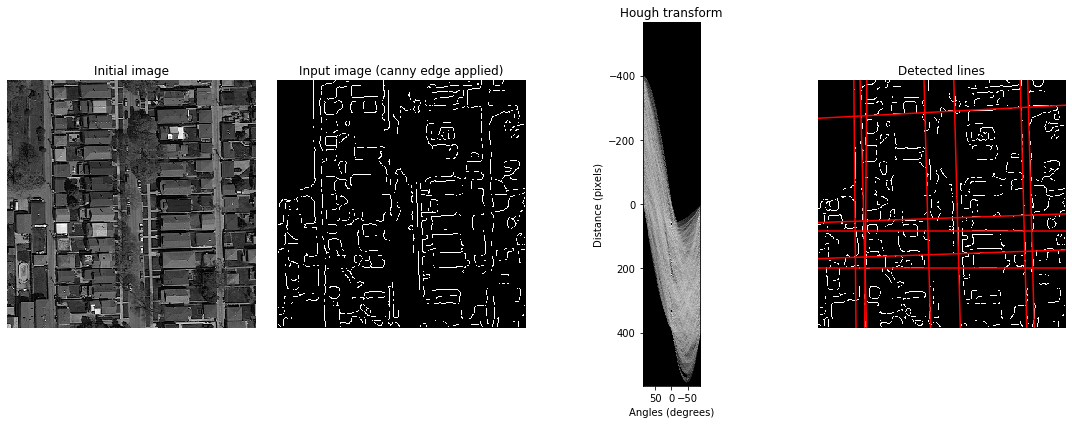

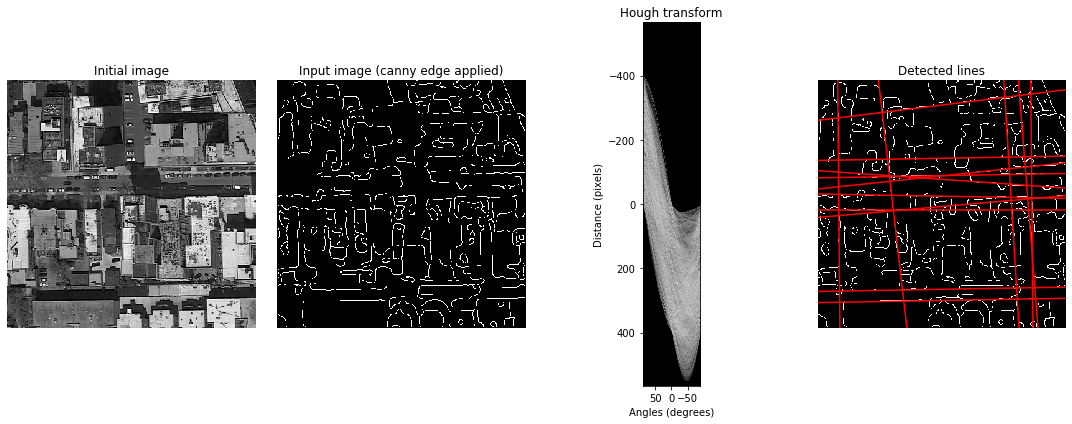

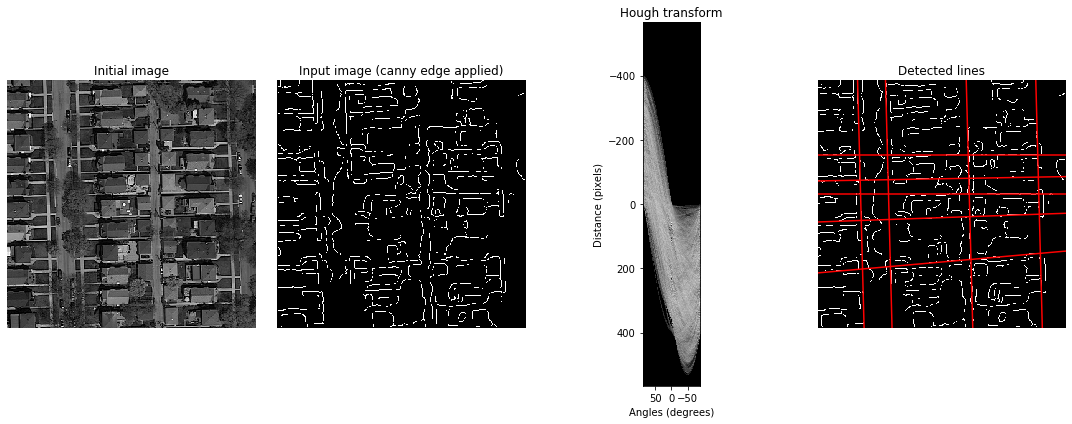

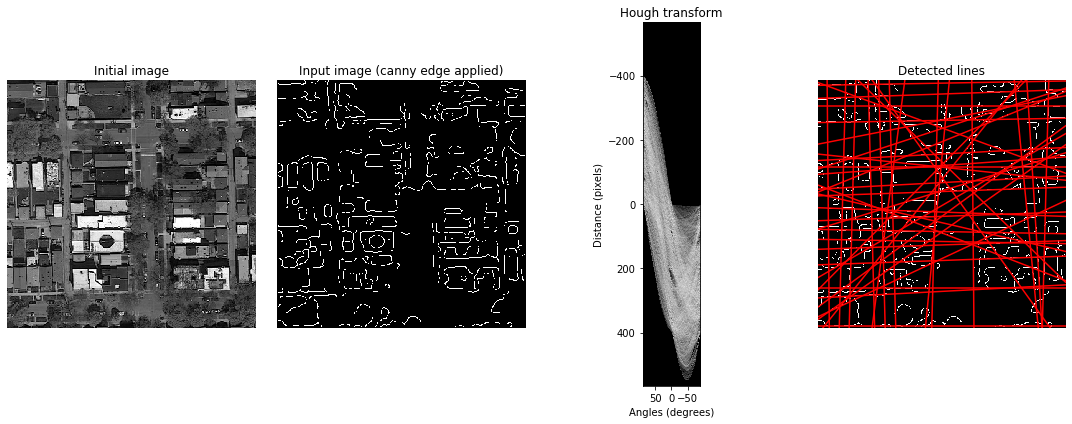

In [12]:
for i in range(np.shape(edges)[0]):
    h, theta, d = hough_line(edges[i][idx_sigma], theta=tested_angles)
    # Generating figure 1
    fig, axes = plt.subplots(1, 4, figsize=(15, 6))
    ax = axes.ravel()
    
    ax[0].imshow(imgs_gray_tr[i], cmap=cm.gray)
    ax[0].set_title('Initial image')
    ax[0].set_axis_off()
    
    ax[1].imshow(edges[i][idx_sigma], cmap=cm.gray)
    ax[1].set_title('Input image (canny edge applied)')
    ax[1].set_axis_off()

    ax[2].imshow(np.log(1 + h),
                 extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
                 cmap=cm.gray, aspect=1/1.5)
    ax[2].set_title('Hough transform')
    ax[2].set_xlabel('Angles (degrees)')
    ax[2].set_ylabel('Distance (pixels)')
    ax[2].axis('image')

    ax[3].imshow(edges[i][idx_sigma], cmap=cm.gray)
    origin = np.array((0, edges[i][idx_sigma].shape[1]))
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        ax[3].plot(origin, (y0, y1), '-r')
    ax[3].set_xlim(origin)
    ax[3].set_ylim((edges[i][idx_sigma].shape[0], 0))
    ax[3].set_axis_off()
    ax[3].set_title('Detected lines')

    plt.tight_layout()
    plt.show()


# Results
### As you can see, results are quite good sometimes but not always, so it can be something to use :) 